# Example of usage Spark OCR for Checkbox  Detection
In this notebook, we will explore how to detect checkboxes in document images, and to obtain a unified representation for checkboxes and texts that we can use in other models.

In [15]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11/"

import os
if AWS_ACCESS_KEY_ID:
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

In [ ]:
#!pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#!pip install ../../python/dist/spark-ocr-5.3.0.tar.gz

## Start Spark Ocr session

In [16]:
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

Spark version: 3.4.2
Spark NLP version: 5.3.0
Spark OCR version: 5.3.0


In [17]:
import pkg_resources
from pyspark.ml import PipelineModel
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

## Load image and display it


    Image #0:
    Origin: file:/home/nmelnik/IdeaProjects/spark-ocr/python/sparkocr/resources/ocr/checkboxes/checkboxes1.png
    Resolution: 0 dpi
    Width: 1700 px
    Height: 2200 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


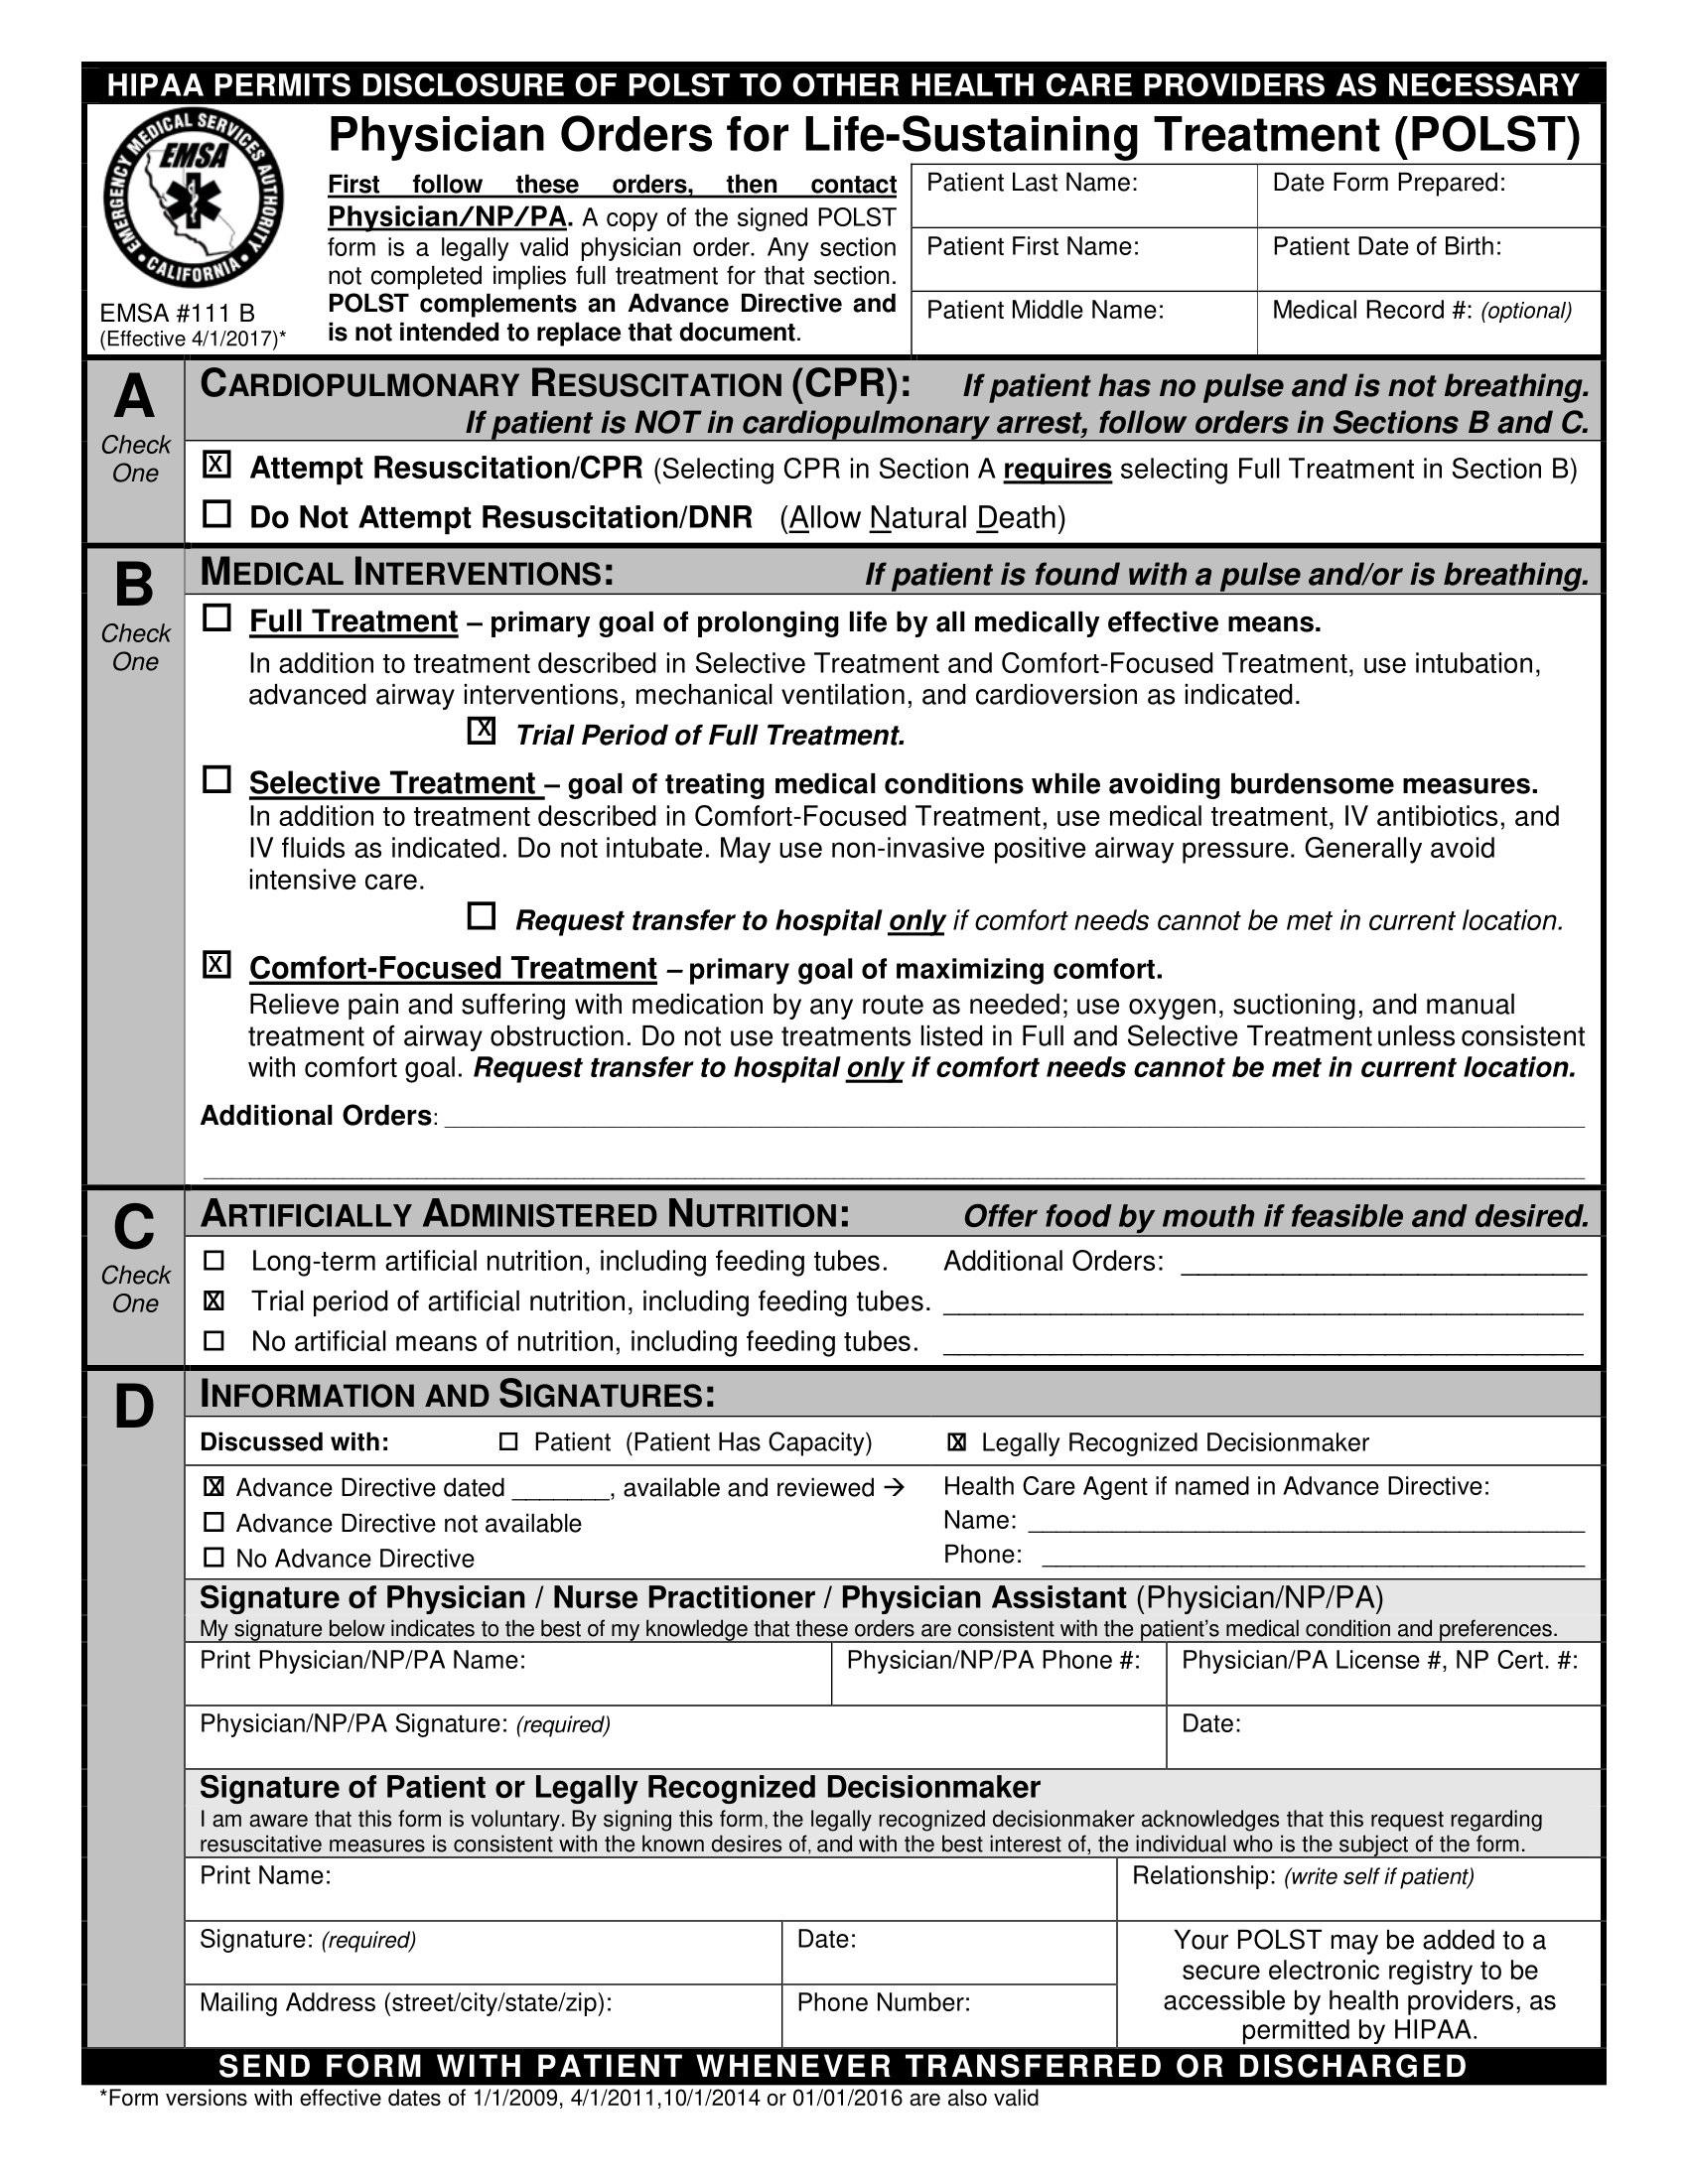

In [18]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/checkboxes/checkboxes1.png')
image_df = spark.read.format("binaryFile").load(imagePath).sort("path")

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

## Define pipeline for checkbox detecton

In [19]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

check_box_detector = ImageCheckBoxDetector \
    .pretrained("checkbox_detector_v1", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setLabels(["No", "Yes"]) \
    .setOutputLabels(["No", "Yes"]) \
    .setScoreThreshold(0.1) \
    .setOutputCol("regions") \
    .setOutputFormat(DetectorOutputFormat.REGIONS)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

pipeline = PipelineModel(stages=[
    binary_to_image,
    check_box_detector,
    draw_regions
])

checkbox_detector_v1 download started this may take some time.
Approximate size to download 265.8 MB


## Run pipleine and display results


    Image #0:
    Origin: file:/home/nmelnik/IdeaProjects/spark-ocr/python/sparkocr/resources/ocr/checkboxes/checkboxes1.png
    Resolution: 0 dpi
    Width: 1700 px
    Height: 2200 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


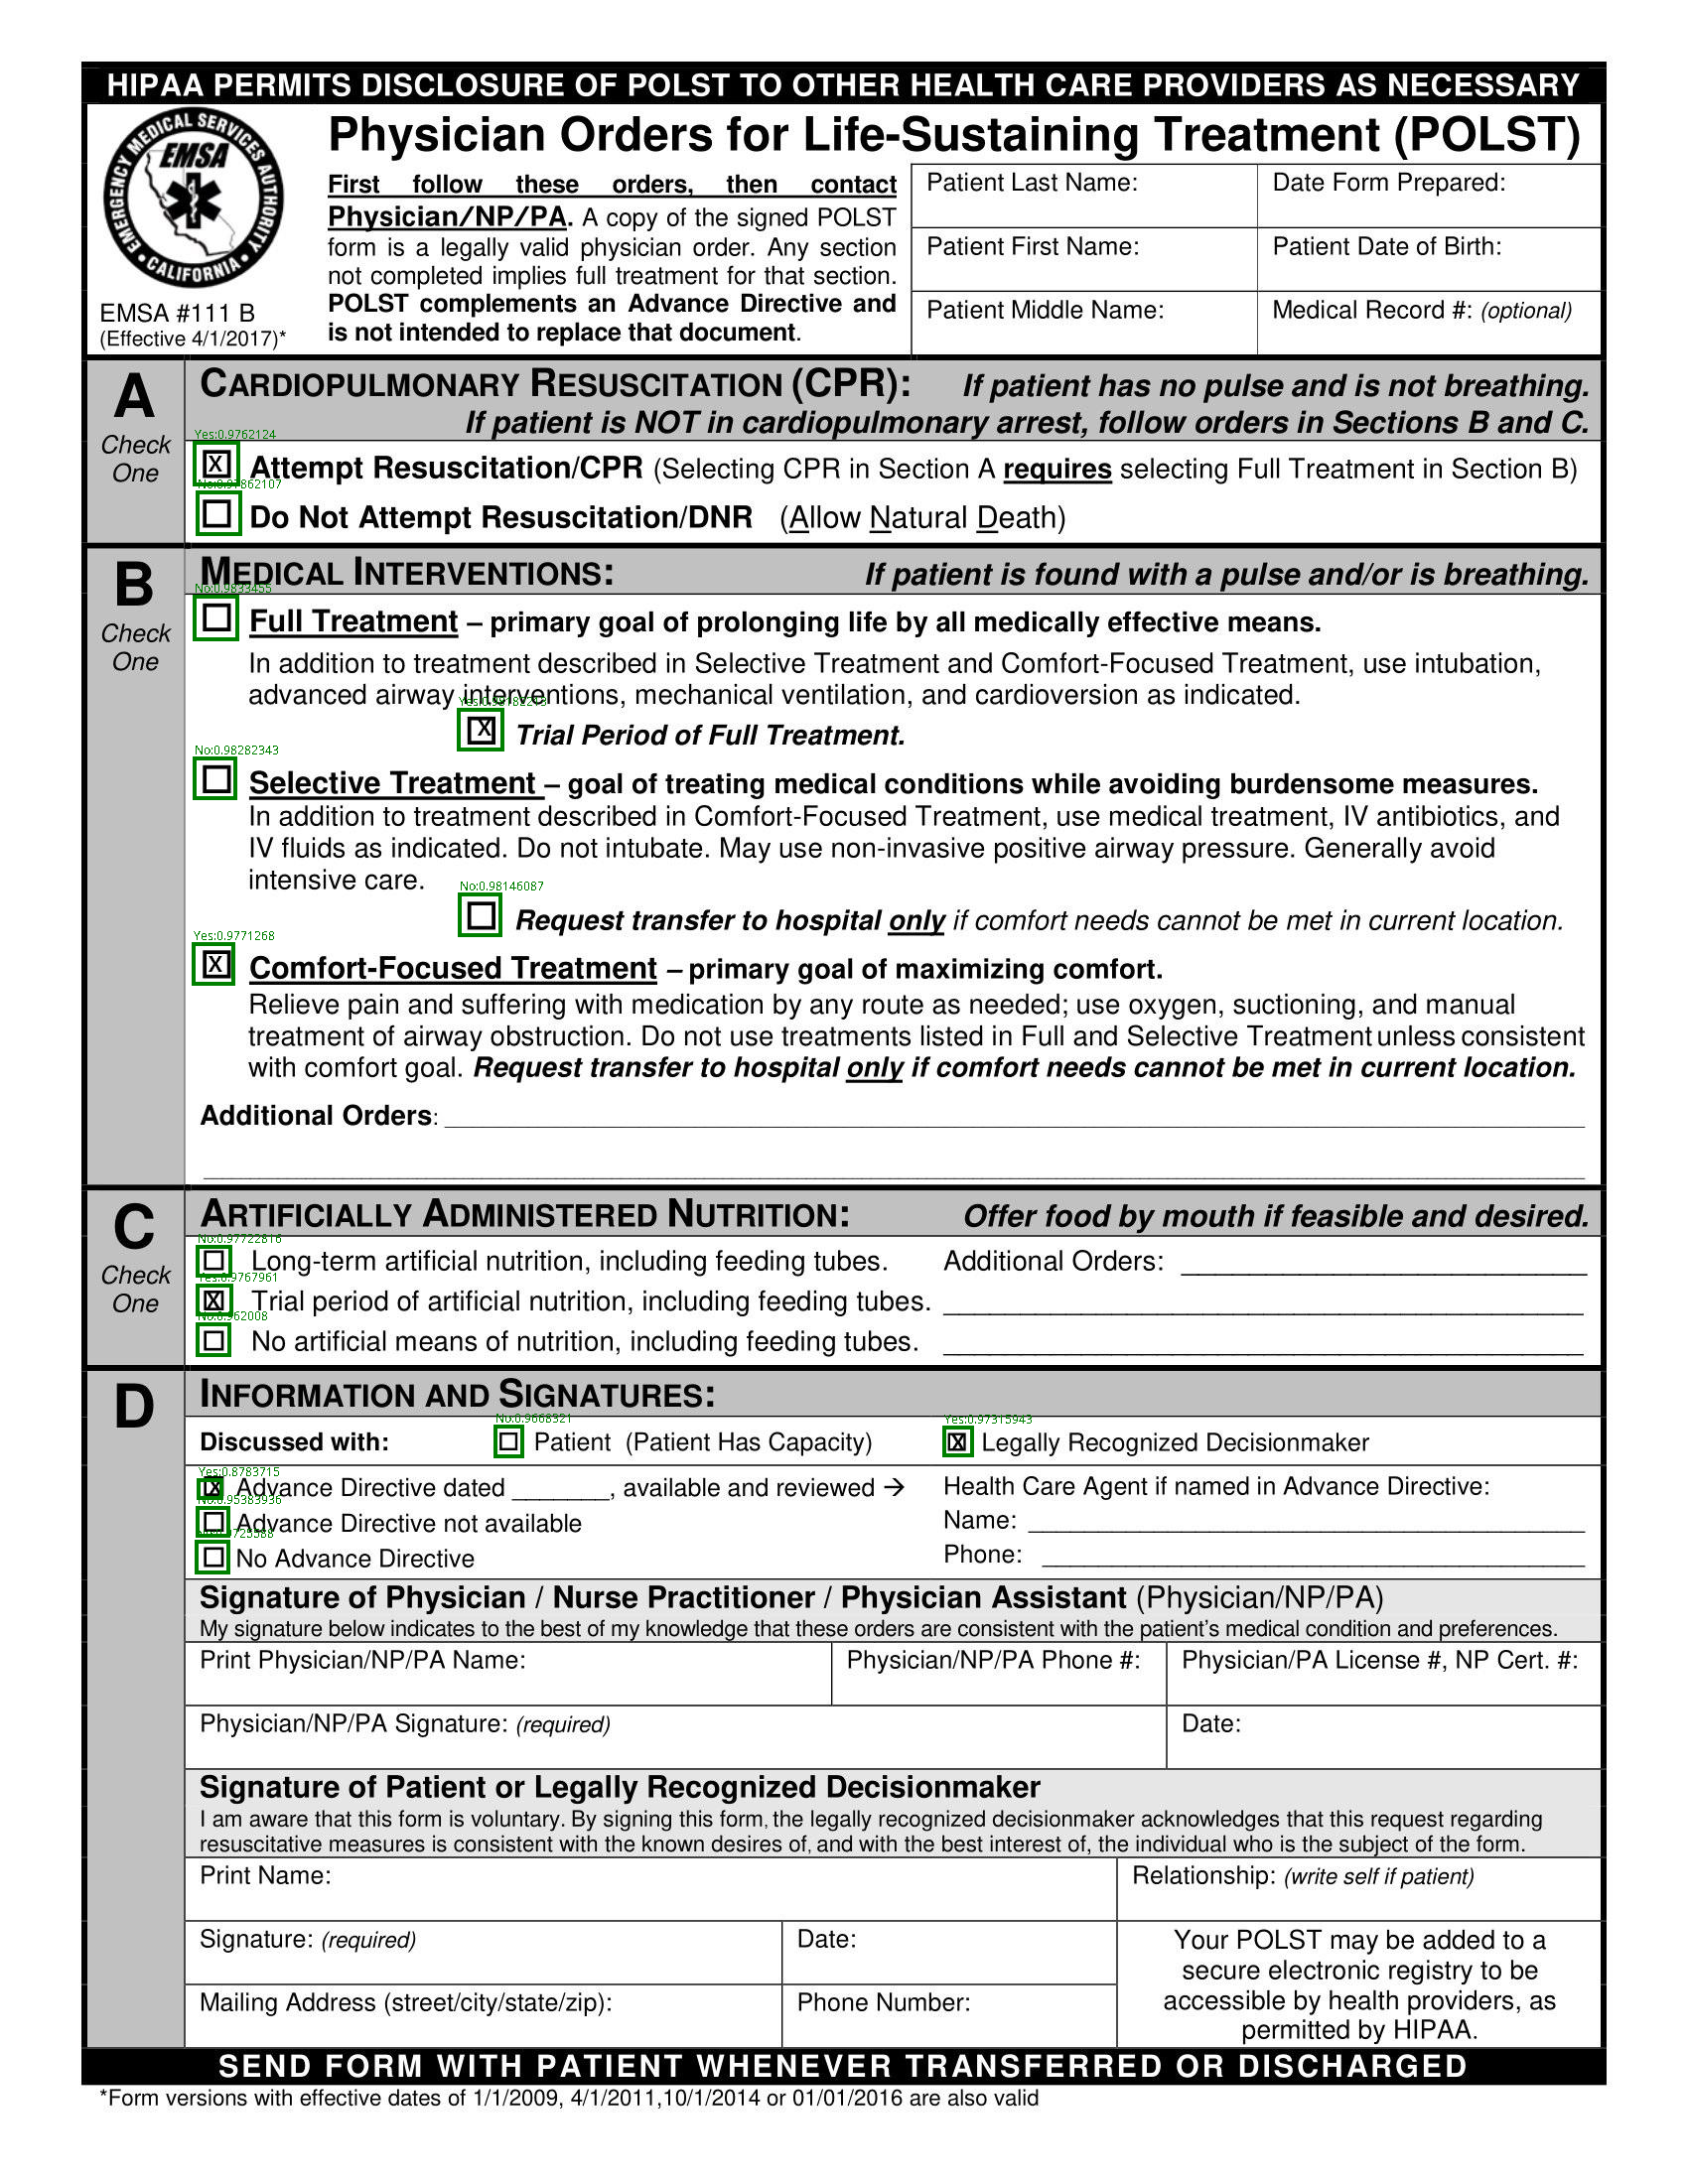

In [20]:
result = pipeline.transform(image_df)
display_images(result, "image_with_regions")

## Define pipeline for replacing checkboxes by text

In [21]:
image2hocr = ImageToHocr().setOutputCol("hocr1")

checkBoxDetector = ImageCheckBoxDetector \
    .pretrained("checkbox_detector_v1", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setLabels(["No", "Yes"]) \
    .setOutputLabels(["No", "Yes"]) \
    .setScoreThreshold(0.1) \
    .setOutputCol("hocr2") \
    .setOutputFormat(DetectorOutputFormat.HOCR)

hocrMerger = HocrMerger() \
    .setOutputCol("hocr") \
    .setInputCols(["hocr1", "hocr2"])

hocrToImage = HocrToImage() \
    .setInputCol("hocr") \
    .setOutputCol("image_hocr")

# Define pipeline
pipeline1 = PipelineModel(stages=[
    binary_to_image,
    image2hocr,
    checkBoxDetector,
    hocrMerger,
    hocrToImage
])

checkbox_detector_v1 download started this may take some time.
Approximate size to download 265.8 MB


## Run pipeline and display results

Estimating resolution as 249



    Image #0:
    Origin: memory
    Resolution: 300 dpi
    Width: 1700 px
    Height: 2200 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


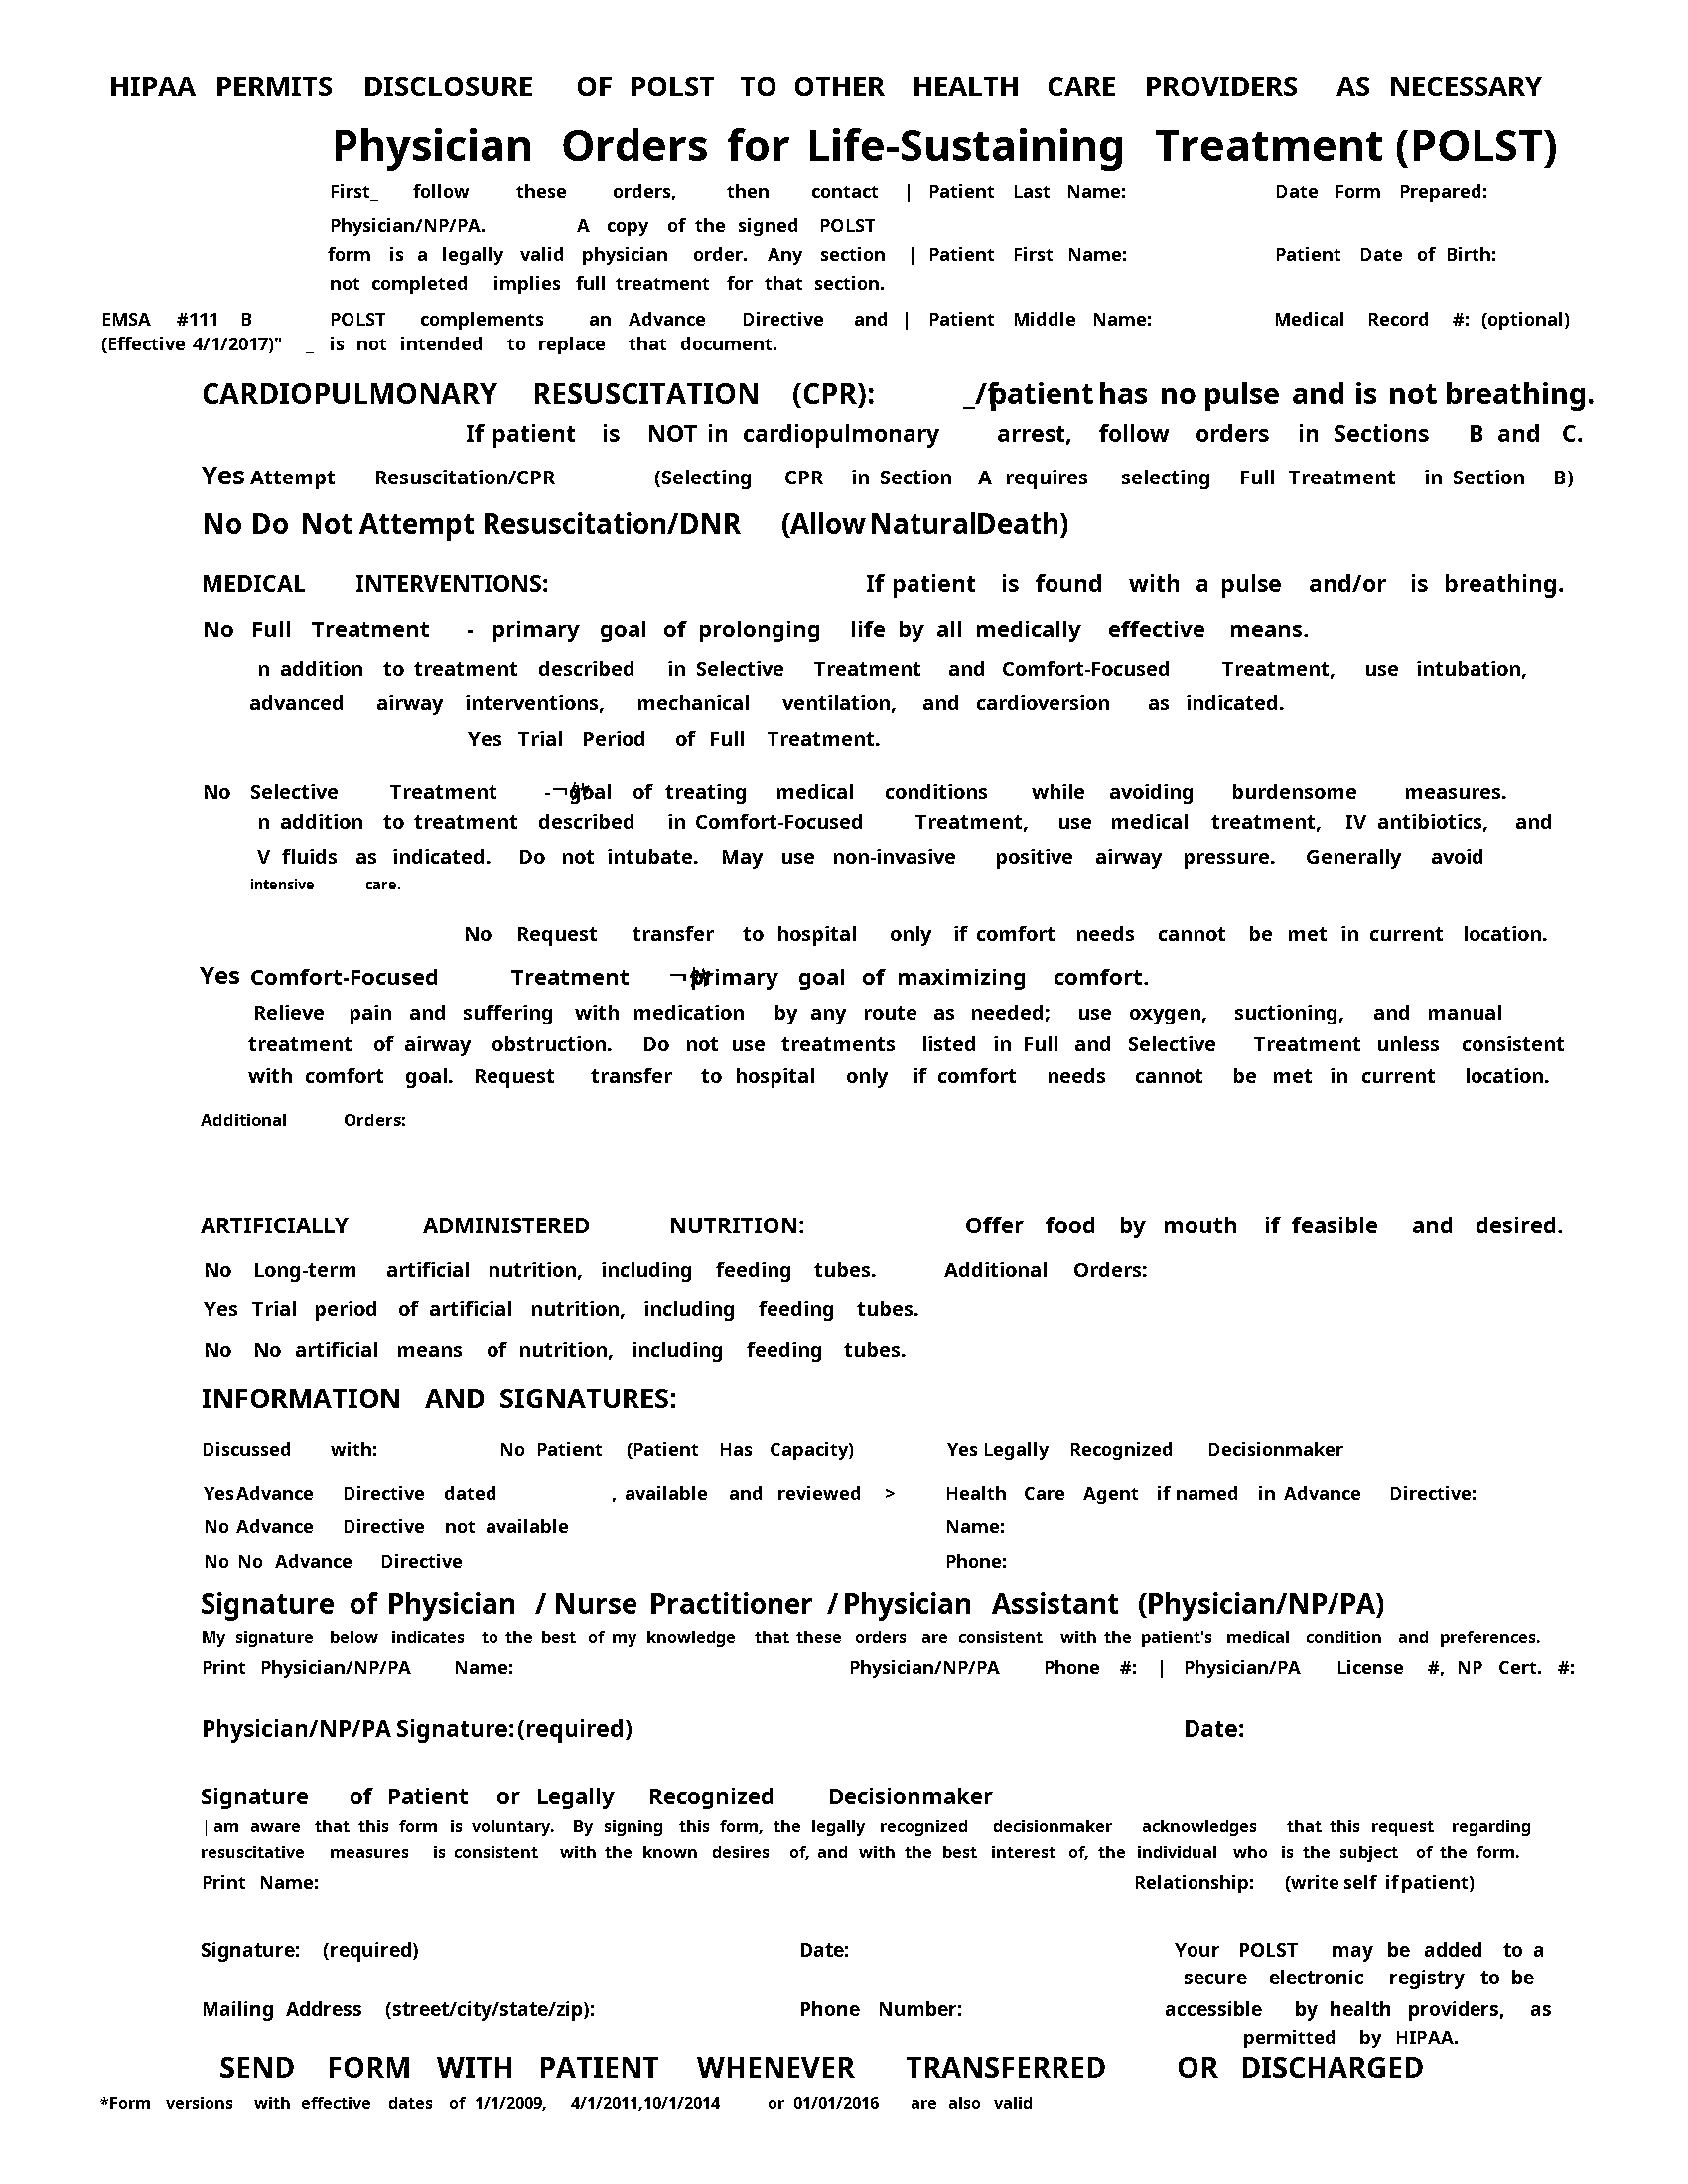

In [22]:
result1 = pipeline1.transform(image_df)
display_images(result1, "image_hocr")

After this, we have both texts and checkboxes in a single column `hocr`, which can be used by downstream tasks such as Visual NER.